In [1]:
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math

2022-10-20 15:08:25.349036: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cvmfs/sft.cern.ch/lcg/releases/MCGenerators/thepeg/2.2.1-8d929/x86_64-centos7-gcc8-opt/lib/ThePEG:/cvmfs/sft.cern.ch/lcg/releases/MCGenerators/herwig++/7.2.1-f3599/x86_64-centos7-gcc8-opt/lib/Herwig:/cvmfs/sft.cern.ch/lcg/views/LCG_101/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/torch/lib:/cvmfs/sft.cern.ch/lcg/views/LCG_101/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/tensorflow:/cvmfs/sft.cern.ch/lcg/views/LCG_101/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/tensorflow/contrib/tensor_forest:/cvmfs/sft.cern.ch/lcg/views/LCG_101/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/tensorflow/python/framework:/cvmfs/sft.cern.ch/lcg/releases/java/8u222-884d8/x86_64-centos7-gcc8-opt/jre/lib/amd64:/cvmfs/sft.cern.ch/lcg/view

In [2]:
train_df = pd.read_csv('train_2Dy.csv',nrows=100000)
test_df = pd.read_csv('test_2Dy.csv',nrows=5000)

In [3]:
X_train = train_df.drop(columns=['y-midplane']).values
X_test = test_df.drop(columns=['y-midplane']).values

y_train = train_df['y-midplane'].values
y_test = test_df['y-midplane'].values

In [4]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test = scaler.fit_transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

In [5]:
model = Sequential()
model.add(Dense(32, input_shape=(104,), activation='relu')) # Add an input shape! (features,)
model.add(Dense(2, activation='linear'))
model.summary() 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                3360      
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 66        
Total params: 3,426
Trainable params: 3,426
Non-trainable params: 0
_________________________________________________________________


2022-10-20 15:08:29.895590: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cvmfs/sft.cern.ch/lcg/releases/MCGenerators/thepeg/2.2.1-8d929/x86_64-centos7-gcc8-opt/lib/ThePEG:/cvmfs/sft.cern.ch/lcg/releases/MCGenerators/herwig++/7.2.1-f3599/x86_64-centos7-gcc8-opt/lib/Herwig:/cvmfs/sft.cern.ch/lcg/views/LCG_101/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/torch/lib:/cvmfs/sft.cern.ch/lcg/views/LCG_101/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/tensorflow:/cvmfs/sft.cern.ch/lcg/views/LCG_101/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/tensorflow/contrib/tensor_forest:/cvmfs/sft.cern.ch/lcg/views/LCG_101/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/tensorflow/python/framework:/cvmfs/sft.cern.ch/lcg/releases/java/8u222-884d8/x86_64-centos7-gcc8-opt/jre/lib/amd64:/cvmfs/sft.cern.ch/lcg/views/LCG_101/

In [6]:
def custom_loss(y, p):
    
    maxval = 1e6
    minval = 1e-9
    pi = 3.14159265359
    
    mu = tf.gather(params=p, indices=[0], axis=1)
    sigma = tf.clip_by_value(tf.gather(params=p, indices=[1], axis=1),minval,maxval)
        
    term = tf.clip_by_value(1.0/tf.math.sqrt(2*pi)/sigma*tf.math.exp(-1*(y-mu)*(y-mu)/(2*sigma*sigma)),minval,maxval)
    NLL = tf.clip_by_value(-1*tf.math.log(term),minval,maxval)
    
    return tf.keras.backend.sum(NLL,axis=1)

In [7]:
model.compile(optimizer='Adam', 
              loss=custom_loss)

In [8]:
es = EarlyStopping(patience=5)

history = model.fit(X_train,
                    y_train,
                    callbacks=[es],
                    epochs=80, 
                    batch_size=64,
                    validation_split=0.2,
                    shuffle=True,
                    verbose=1)

2022-10-20 15:08:30.014085: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-10-20 15:08:30.014928: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2894560000 Hz


Epoch 1/80
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
1250/1250 [==============================] - 2s 1ms/step - loss: 3.6899 - val_loss: 2.4270
Epoch 2/80
1250/1250 [==============================] - 1s 968us/step - loss: 2.1661 - val_loss: 1.9166
Epoch 3/80
1250/1250 [==============================] - 1s 995us/step - loss: 1.8425 - val_loss: 1.7084
Epoch 4/80
1250/1250 [==============================] - 1s 973us/step - loss: 1.6977 - val_loss: 1.6090
Epoch 5/80
1250/1250 [==============================] - 1s 985us/step - loss: 1.6174 - val_loss: 1.5971
Epoch 6/80
1250/1250 [==============================] - 1s 953us/step - loss: 1.5712 - val_loss: 1.4746
Epoch 7/80
1250/1250 [==============================] - 1s 964us/step - loss: 1.4939 - val_loss: 1.4283
Epoch 8/80
1250/1250 [==============================] - 1s 948us/step - loss: 1.4560 - val_loss: 1.4117
Epoch 9/80
1250/1250 [==========

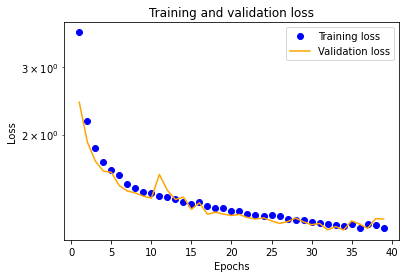

In [9]:
history_dict = history.history
loss_values = history_dict['loss'] 
val_loss_values = history_dict['val_loss'] 
epochs = range(1, len(loss_values) + 1) 
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'orange', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yscale('Log')
plt.legend()
#plt.savefig('/home/jieun201/fullprecision400e_yprofile/loss.png')

In [10]:
#model.save('models_1Dy/gausstest.keras')

In [11]:
p_test = model.predict(X_test)
np.savetxt("test_2DyGaus.csv", p_test, delimiter=",")

In [12]:
p_test = model.predict(X_test)
df = pd.DataFrame(p_test,columns=['mu','sigma'])
df['ytrue'] = y_test
df.to_csv("test_1DxGaus.csv",header=False,index=False)

In [13]:
residuals = y_test - p_test[:,0]

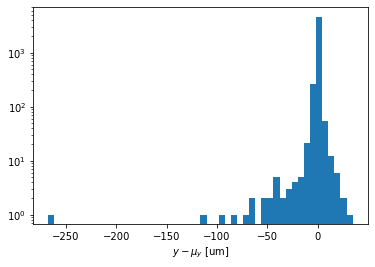

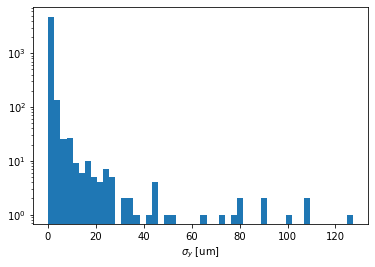

In [14]:
plt.hist(residuals,bins=50)
plt.yscale('Log')
plt.xlabel(r'$y-\mu_y$ [um]')
plt.show()

plt.hist(p_test[:,1],bins=50);
plt.yscale('Log')
plt.xlabel(r'$\sigma_y$ [um]')
plt.show()

In [15]:
pulls = residuals/p_test[:,1]
print(np.mean(pulls),np.std(pulls))

-0.09023056315615215 0.94226300215427


Text(0.5, 0, 'pull')

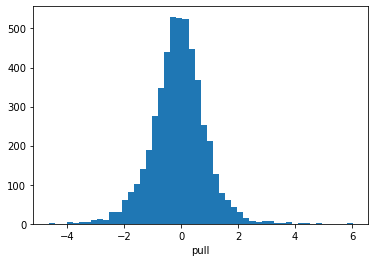

In [16]:
plt.hist(pulls,bins=50);
plt.xlabel('pull')

In [17]:
df_2d = pd.DataFrame(p_test,columns=['mu','sigma'])
df_2d['ytrue'] = y_test
df_2d.head()

,mu,sigma,ytrue
0,-5.556272,0.675596,-5.269646
1,13.094858,0.566901,12.832723
2,17.101698,1.894745,16.483230
3,-10.159347,1.640494,-9.731144
4,5.714094,0.431259,5.776402


In [18]:
df_1d = pd.read_csv('test_1DyGaus.csv',header=None,names=['mu','sigma','ytrue'])
df_1d.head()

,mu,sigma,ytrue
0,-4.503408,2.154454,-4.155753
1,5.249463,1.461508,5.268802
2,0.519554,1.639170,-1.388992
3,16.519974,3.168198,4.737947
4,-2.598370,1.488059,-4.446499


Text(0.5, 0, '$y-\\mu_y$ [um]')

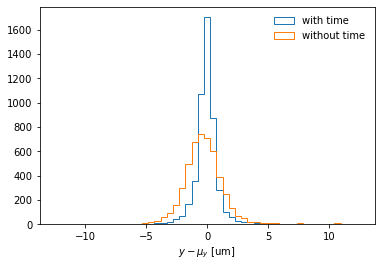

In [22]:
plt.hist(df_2d['ytrue'] - df_2d['mu'],histtype='step',bins=np.linspace(-12.5,12.5,50),label=r'with time');
plt.hist(df_1d['ytrue'] - df_1d['mu'],histtype='step',bins=np.linspace(-12.5,12.5,50),label=r'without time');
plt.legend(frameon=False)
plt.xlabel(r'$y-\mu_y$ [um]')

Text(0.5, 0, '$\\sigma_y$ [um]')

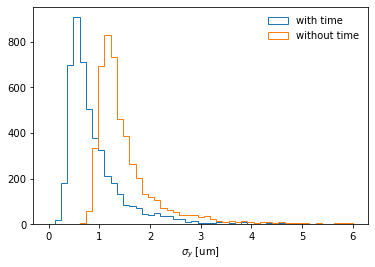

In [23]:
plt.hist(df_2d['sigma'],histtype='step',bins=np.linspace(0,6,50),label=r'with time');
plt.hist(df_1d['sigma'],histtype='step',bins=np.linspace(0,6,50),label=r'without time');
plt.legend(frameon=False)
plt.xlabel(r'$\sigma_y$ [um]')